In [46]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pprint import pprint

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.cluster import KMeans
from sklearn.manifold import TSNE

from keras.datasets import fashion_mnist
from keras.utils.np_utils import to_categorical
from keras.models import Model, Sequential
from keras.layers import Input, Dense, Dropout, Flatten, Conv2D, MaxPool2D, UpSampling2D, Reshape
from keras.optimizers import Adam
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import EarlyStopping

In [2]:
(x_train, y_train), (x_test, y_test) = fashion_mnist.load_data()

In [3]:
print("x_train shape: {}, y_train shape: {}".format(x_train.shape, y_train.shape))

x_train shape: (60000, 28, 28), y_train shape: (60000,)


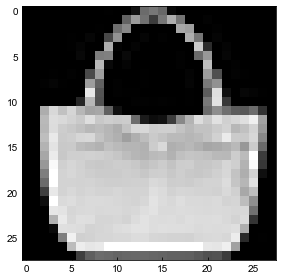

In [4]:
plt.imshow(x_train[100], cmap='gray')

In [5]:
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.1)

In [6]:
x_train = x_train.reshape(len(x_train), 28, 28, 1)
x_val = x_val.reshape(len(x_val), 28, 28, 1)
x_test = x_test.reshape(len(x_test), 28, 28, 1)

In [7]:
print(x_train.shape)
print(x_val.shape)

(54000, 28, 28, 1)
(6000, 28, 28, 1)


In [8]:
x_train = x_train.astype('float32')/255.
x_val = x_val.astype('float32')/255.
x_test = x_test.astype('float32')/255.

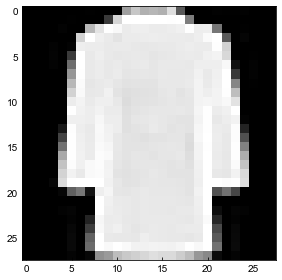

In [9]:
plt.imshow(x_train[10].reshape(28,28), cmap='gray')

In [10]:
y_train = to_categorical(y_train)
y_val = to_categorical(y_val)

In [43]:
# autoencoder
input_dim = x_train.shape[1]
encoding_dim = 32

compression_factor = float(input_dim)/encoding_dim
print("Compression factor: {}".format(compression_factor))

autoencoder = Sequential()

# Encoder Layers
autoencoder.add(Conv2D(64, (3,3), activation='relu', padding='same',
                      input_shape=x_train.shape[1:]))
autoencoder.add(MaxPool2D((2,2), padding='same'))
autoencoder.add(Dropout(0.3))
autoencoder.add(Conv2D(32, (3,3), activation='relu', padding='same'))
autoencoder.add(MaxPool2D((2,2), padding='same'))
autoencoder.add(Dropout(0.3))
autoencoder.add(Conv2D(16, (3,3), strides=(2,2), activation='relu', padding='same'))
autoencoder.add(MaxPool2D((2,2), padding='same'))
autoencoder.add(Dropout(0.3))

# Flatten encoding for visualization
autoencoder.add(Flatten())
autoencoder.add(Dense(units=128, activation='relu'))
autoencoder.add(Dropout(0.3))
autoencoder.add(Dense(units=32, activation='relu'))
autoencoder.add(Dropout(0.3))
autoencoder.add(Dense(10, activation='softmax'))

# Decoder Layers
autoencoder.add(Dense(units=32, activation='relu'))
autoencoder.add(Dropout(0.3))
autoencoder.add(Dense(units=128, activation='relu'))
autoencoder.add(Dropout(0.3))
autoencoder.add(Reshape((4,4,8)))
autoencoder.add(Conv2D(16, (3,3), activation='relu', padding='same'))
autoencoder.add(UpSampling2D((2,2)))
autoencoder.add(Dropout(0.3))
autoencoder.add(Conv2D(23, (3,3), activation='relu', padding='same'))
autoencoder.add(UpSampling2D((2,2)))
autoencoder.add(Dropout(0.3))
autoencoder.add(Conv2D(64, (3,3), activation='relu'))
autoencoder.add(UpSampling2D((2,2)))
autoencoder.add(Dropout(0.3))
autoencoder.add(Conv2D(1, (3,3), activation='sigmoid', padding='same'))

autoencoder.summary()

W0705 15:45:36.638007  9164 deprecation.py:506] From C:\Anaconda3\envs\Development\lib\site-packages\keras-2.2.4-py3.7.egg\keras\backend\tensorflow_backend.py:3721: calling dropout (from tensorflow.python.ops.nn_ops) with keep_prob is deprecated and will be removed in a future version.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


Compression factor: 0.875
Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_32 (Conv2D)           (None, 28, 28, 64)        640       
_________________________________________________________________
max_pooling2d_15 (MaxPooling (None, 14, 14, 64)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 14, 14, 64)        0         
_________________________________________________________________
conv2d_33 (Conv2D)           (None, 14, 14, 32)        18464     
_________________________________________________________________
max_pooling2d_16 (MaxPooling (None, 7, 7, 32)          0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 7, 7, 32)          0         
_________________________________________________________________
conv2d_34 (Conv2D)          

In [44]:
# encoder
encoder = Model(inputs=autoencoder.input, 
               outputs=autoencoder.get_layer('dense_19').output)

encoder.summary()

Model: "model_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_32_input (InputLayer) (None, 28, 28, 1)         0         
_________________________________________________________________
conv2d_32 (Conv2D)           (None, 28, 28, 64)        640       
_________________________________________________________________
max_pooling2d_15 (MaxPooling (None, 14, 14, 64)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 14, 14, 64)        0         
_________________________________________________________________
conv2d_33 (Conv2D)           (None, 14, 14, 32)        18464     
_________________________________________________________________
max_pooling2d_16 (MaxPooling (None, 7, 7, 32)          0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 7, 7, 32)          0   

In [45]:
autoencoder.compile(loss='binary_crossentropy', optimizer = 'adam', metrics=["accuracy"])

In [46]:
early_stopping = EarlyStopping(min_delta=1e-6)
hist = autoencoder.fit(x_train, x_train, epochs=100, batch_size=256,
                 validation_data=(x_val, x_val), callbacks=[early_stopping])

Train on 54000 samples, validate on 6000 samples
Epoch 1/100
54000/54000 [==============================] - 16s 299us/step - loss: 0.4903 - acc: 0.4881 - val_loss: 0.3868 - val_acc: 0.4855
Epoch 2/100
54000/54000 [==============================] - 14s 264us/step - loss: 0.3955 - acc: 0.4881 - val_loss: 0.3634 - val_acc: 0.4922
Epoch 3/100
54000/54000 [==============================] - 14s 265us/step - loss: 0.3808 - acc: 0.4897 - val_loss: 0.3540 - val_acc: 0.4923
Epoch 4/100
54000/54000 [==============================] - 14s 264us/step - loss: 0.3740 - acc: 0.4910 - val_loss: 0.3490 - val_acc: 0.4947
Epoch 5/100
54000/54000 [==============================] - 14s 264us/step - loss: 0.3696 - acc: 0.4920 - val_loss: 0.3478 - val_acc: 0.4942
Epoch 6/100
54000/54000 [==============================] - 14s 264us/step - loss: 0.3668 - acc: 0.4925 - val_loss: 0.3472 - val_acc: 0.4945
Epoch 7/100
54000/54000 [==============================] - 14s 265us/step - loss: 0.3644 - acc: 0.4930 - val_lo

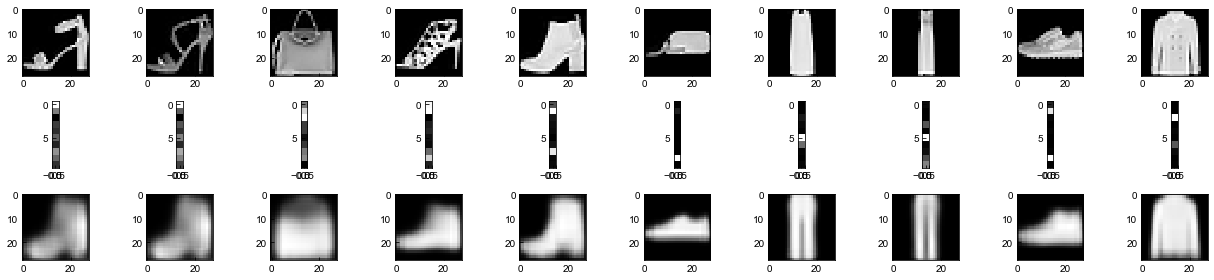

In [47]:
num_images = 10
np.random.seed(10)
random_test_images = np.random.randint(x_test.shape[0], size=num_images)

encoded_imgs = encoder.predict(x_test)
decoded_imgs = autoencoder.predict(x_test)

plt.figure(figsize=(18, 4))

for i, image_idx in enumerate(random_test_images):
    # plot original image
    ax = plt.subplot(3, num_images, i+1)
    plt.imshow(x_test[image_idx].reshape(28,28))
    plt.gray()
    
    # plot encoded image
    ax = plt.subplot(3, num_images, num_images+i+1)
    plt.imshow(encoded_imgs[image_idx].reshape(10,1))
    plt.gray()
    
    # plot decoded image
    ax = plt.subplot(3, num_images, 2*num_images+i+1)
    plt.imshow(decoded_imgs[image_idx].reshape(28,28))
    plt.gray()

In [48]:
kmeans = KMeans(n_clusters=10)
clustered_training_set = kmeans.fit_predict(encoded_imgs)

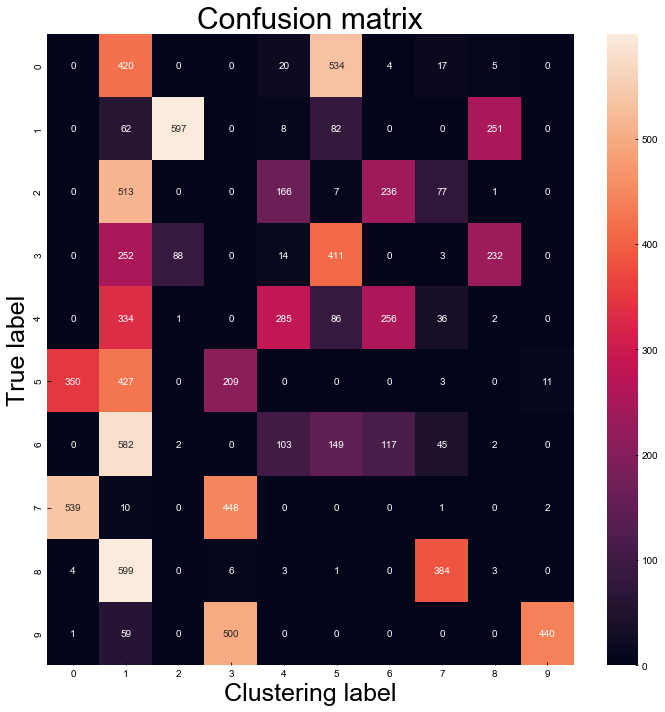

In [49]:
# Observe and compare clustering result with actual label using confusion matrix
cm = confusion_matrix(y_test, clustered_training_set)
plt.figure(figsize=(10, 10))
sns.heatmap(cm, annot=True, fmt="d")
plt.title("Confusion matrix", fontsize=30)
plt.ylabel('True label', fontsize=25)
plt.xlabel('Clustering label', fontsize=25)
plt.show()

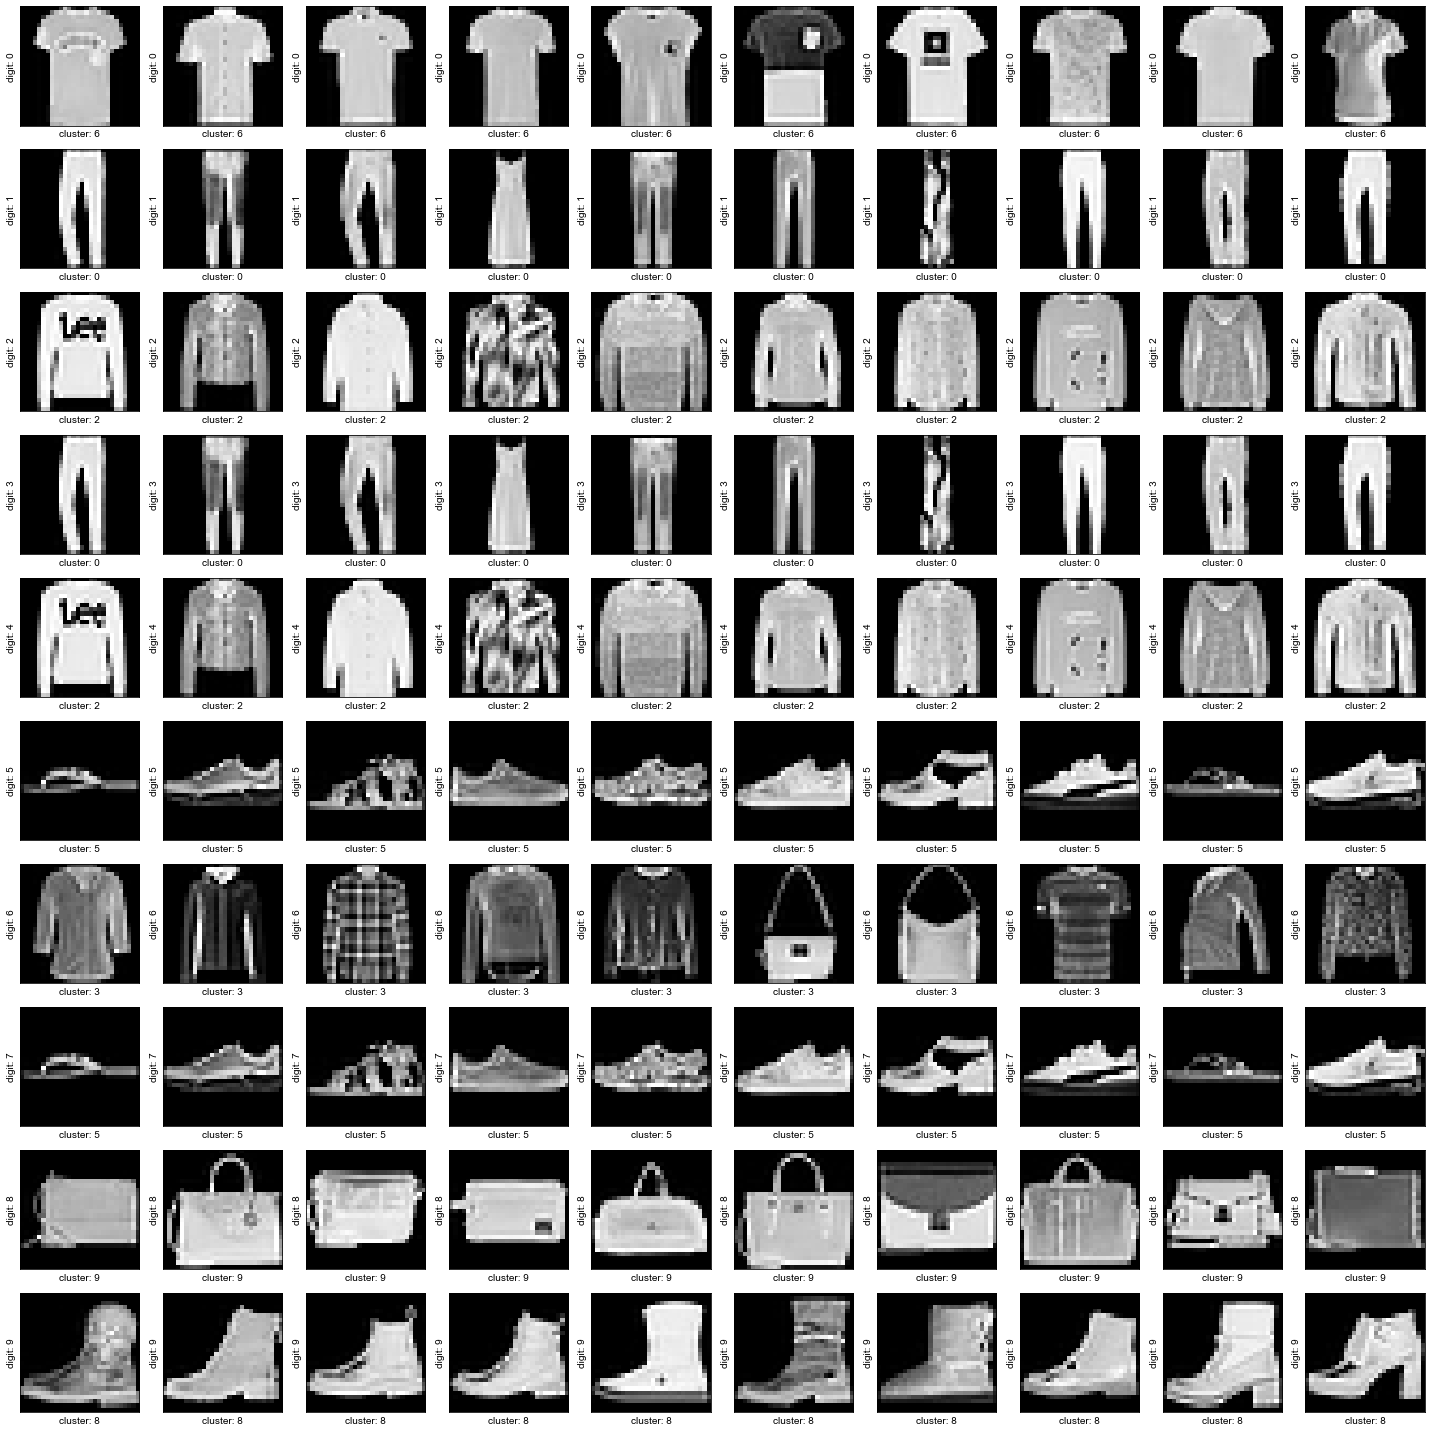

In [23]:
# Plot the actual pictures grouped by clustering
fig = plt.figure(figsize=(20,20))
for r in range(10):
    cluster = cm[r].argmax()
    for c, val in enumerate(x_test[clustered_training_set == cluster][0:10]):
        fig.add_subplot(10, 10, 10*r+c+1)
        plt.imshow(val.reshape((28,28)))
        plt.gray()
        plt.xticks([])
        plt.yticks([])
        plt.xlabel('cluster: '+str(cluster))
        plt.ylabel('digit: '+str(r))

In [29]:
# TSNE
tsne = TSNE(n_components=2, verbose=2, perplexity=40, n_iter=300)
tsne_results = tsne.fit_transform(encoded_imgs)

[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 10000 samples in 0.073s...
[t-SNE] Computed neighbors for 10000 samples in 14.531s...
[t-SNE] Computed conditional probabilities for sample 1000 / 10000
[t-SNE] Computed conditional probabilities for sample 2000 / 10000
[t-SNE] Computed conditional probabilities for sample 3000 / 10000
[t-SNE] Computed conditional probabilities for sample 4000 / 10000
[t-SNE] Computed conditional probabilities for sample 5000 / 10000
[t-SNE] Computed conditional probabilities for sample 6000 / 10000
[t-SNE] Computed conditional probabilities for sample 7000 / 10000
[t-SNE] Computed conditional probabilities for sample 8000 / 10000
[t-SNE] Computed conditional probabilities for sample 9000 / 10000
[t-SNE] Computed conditional probabilities for sample 10000 / 10000
[t-SNE] Mean sigma: 0.652095
[t-SNE] Computed conditional probabilities in 0.485s
[t-SNE] Iteration 50: error = 93.3464813, gradient norm = 0.0066884 (50 iterations in 6.449s)
[t-SNE] 

In [39]:
print(tsne_results.shape)
print(y_test.shape)
print(y_test)

(10000, 2)
(10000,)
[9 2 1 ... 8 1 5]


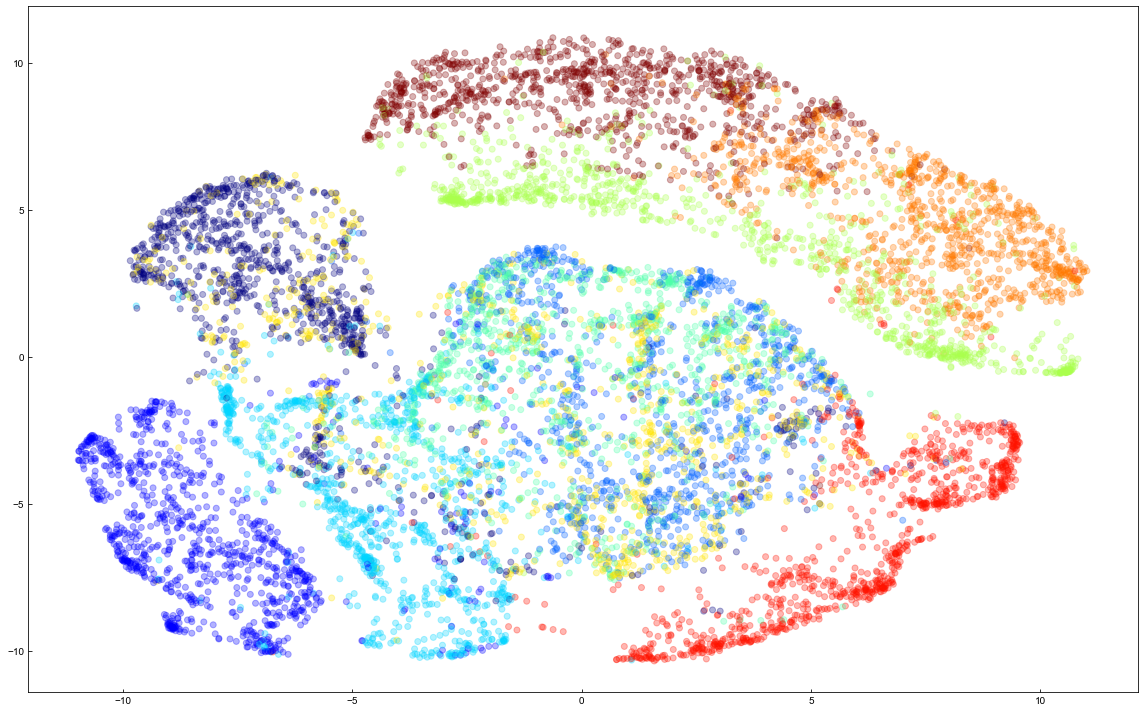

In [50]:
plt.figure(figsize=(16,10))
plt.scatter(
    x=tsne_results[:,0],
    y=tsne_results[:,1],
    alpha=0.3,
    c=y_test,
    cmap='jet'
)
plt.show()